# Task 1: Acquire preprocess, and analyze the data

## Imports

In [127]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, accuracy_score, precision_score,
    recall_score, f1_score, r2_score, classification_report, make_scorer
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict,
    cross_validate, KFold, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler


Load Data

In [128]:
# Load the dataset into a Pandas DataFrame
path = './'
df1 = pd.read_csv(path + 'data/boston.csv')
df2 = pd.read_csv(path + 'data//wine_data.csv')

def stats(df):
    mean = df.mean()
    median = df.median()
    mode = df.mode().iloc[0]
    standard_deviation = df.std()
    variance = df.var()
    return mean, median, mode, standard_deviation, variance

## Dataset 1: boston housing

There are 0 rows with missing values.
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO       LSTAT  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534   12

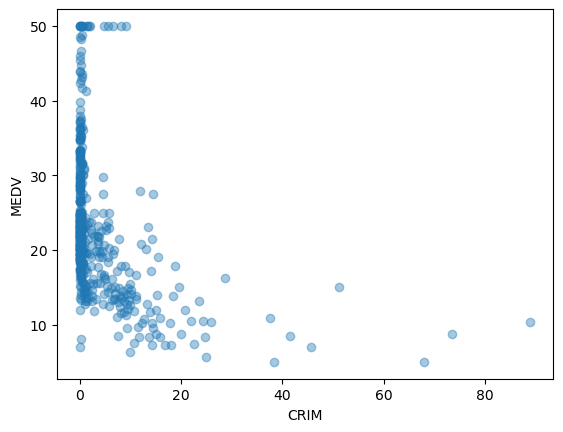

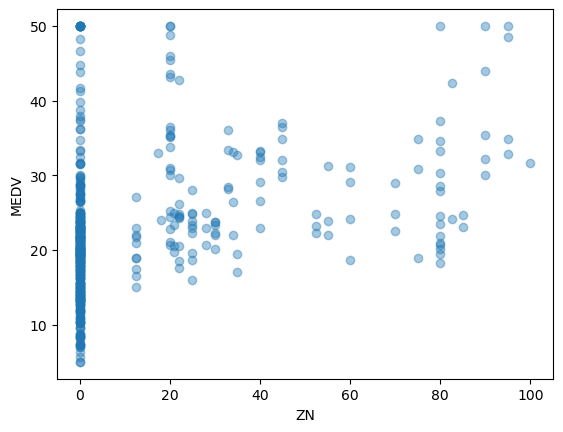

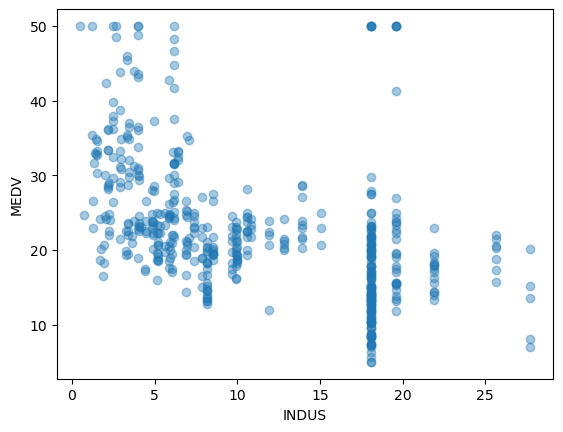

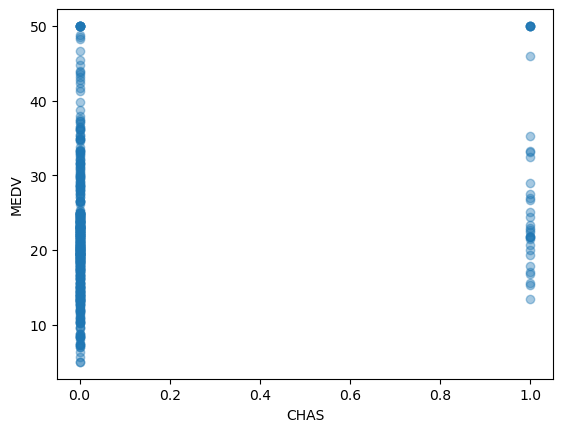

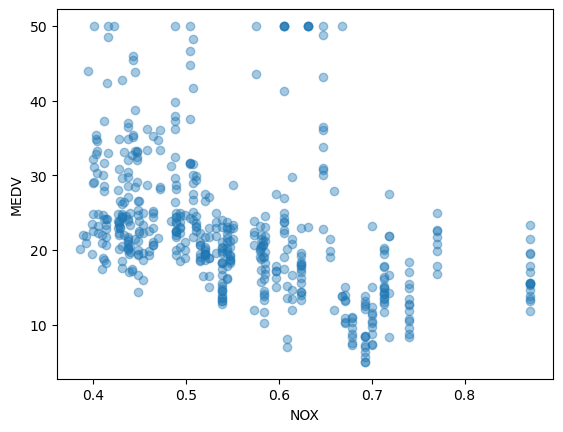

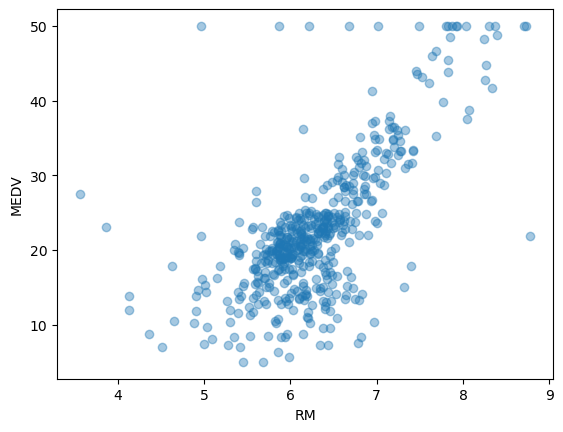

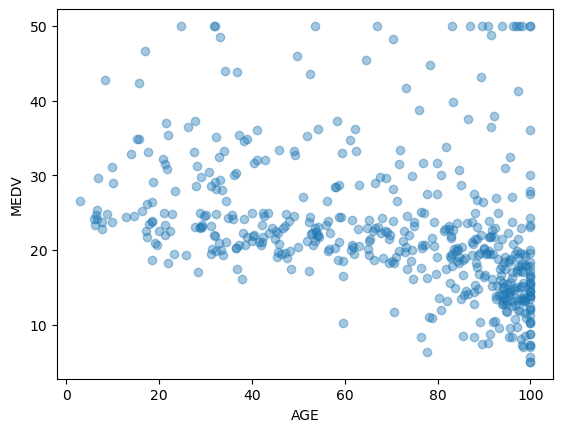

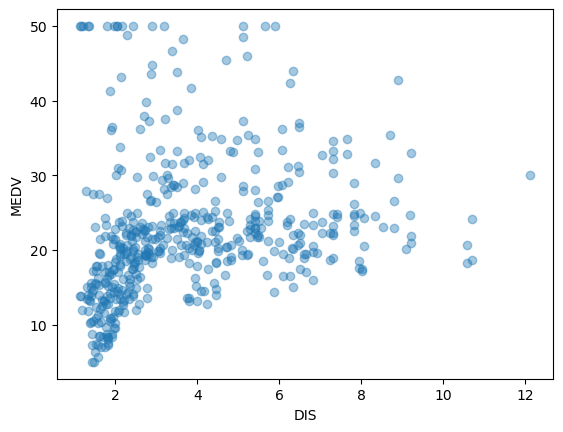

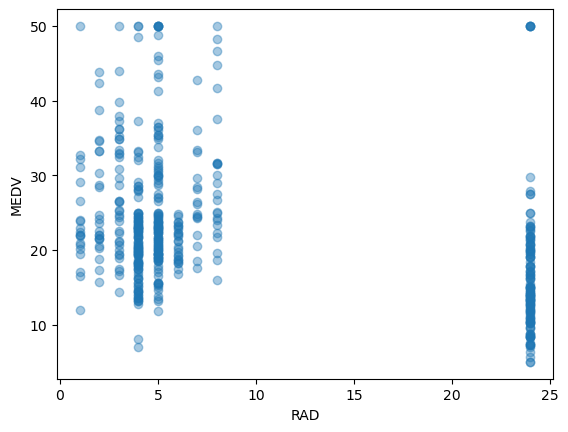

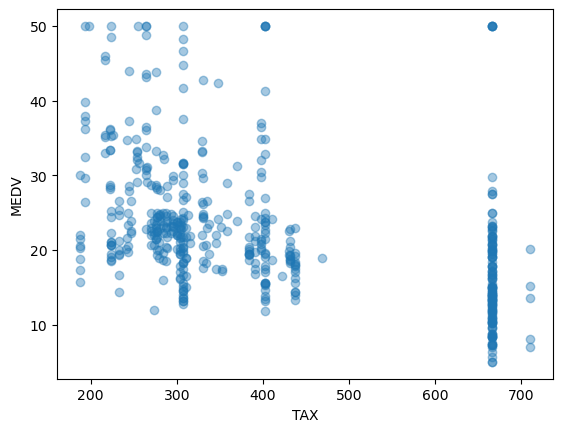

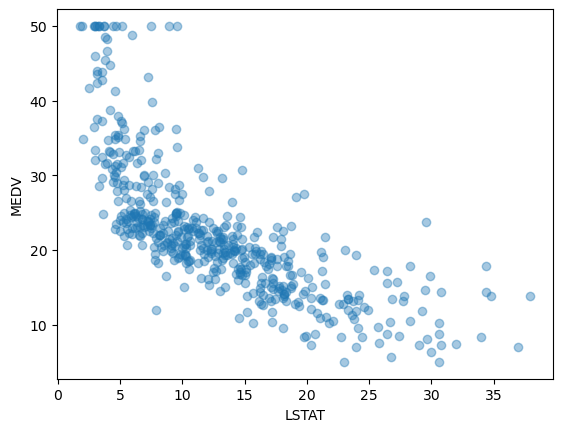

In [129]:

def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

def handle_missing_values(df, missing_value_identifier='?'):
    missing_rows = df[df.eq(missing_value_identifier).any(axis=1)]
    print(f"There are {len(missing_rows)} rows with missing values.")
    return df.drop(missing_rows.index)

def convert_to_numeric(df):
    for column in df.columns:
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            print(f"Column '{column}' contains non-numeric data.")
            malformed_rows = df[~df[column].apply(lambda x: isinstance(x, (int, float)))]
            print(f"Removing {len(malformed_rows)} malformed rows from column '{column}'.")
            df = df.drop(malformed_rows.index)
    return df

def plot_features_against_target(df, features, target):
    for feature in features:
        plt.scatter(df[[feature]], df[[target]], alpha=0.4)
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.show()

# Dropping the column 'B' due to ethical reasons
df1 = drop_columns(df1, ['B'])

# Handling missing values and converting columns to numeric type
df1 = handle_missing_values(df1)
df1 = convert_to_numeric(df1)

# Computing and displaying basic statistics on the data
print(df1.describe())

# Plotting some of the numerical features against the target variable 'MEDV'
features_to_plot = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'LSTAT']
plot_features_against_target(df1, features_to_plot, 'MEDV')


## Dataset 2: Wine

There are 0 rows with missing values.
            Class     Alcohol  Malic acid         Ash  Alcalinity of ash  \
count  178.000000  178.000000  178.000000  178.000000         178.000000   
mean     1.938202   13.000618    2.336348    2.366517          19.494944   
std      0.775035    0.811827    1.117146    0.274344           3.339564   
min      1.000000   11.030000    0.740000    1.360000          10.600000   
25%      1.000000   12.362500    1.602500    2.210000          17.200000   
50%      2.000000   13.050000    1.865000    2.360000          19.500000   
75%      3.000000   13.677500    3.082500    2.557500          21.500000   
max      3.000000   14.830000    5.800000    3.230000          30.000000   

        Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  \
count  178.000000     178.000000  178.000000            178.000000   
mean    99.741573       2.295112    2.029270              0.361854   
std     14.282484       0.625851    0.998859              0.124453 

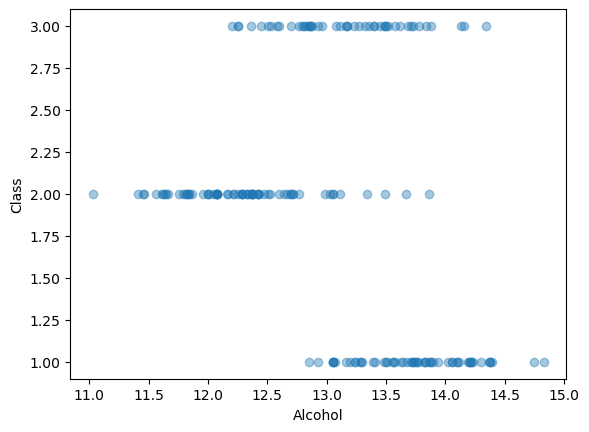

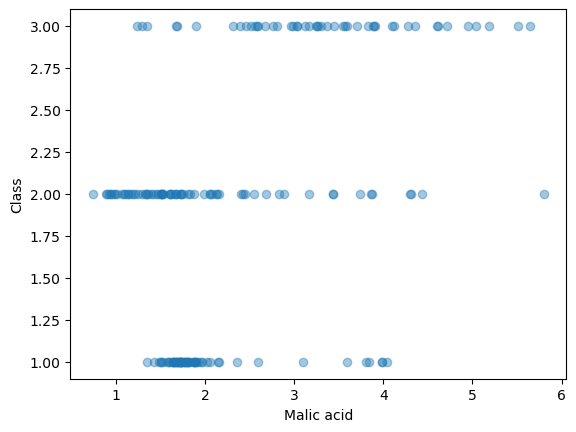

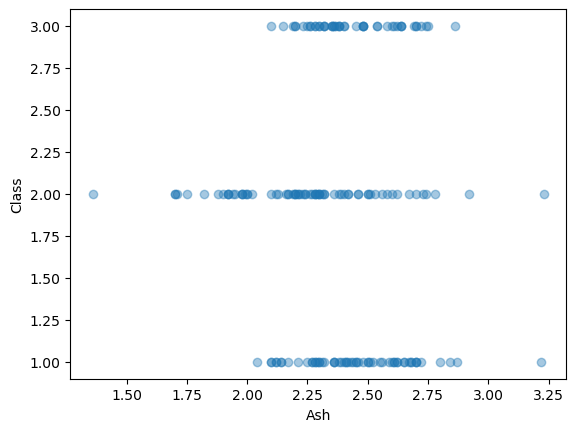

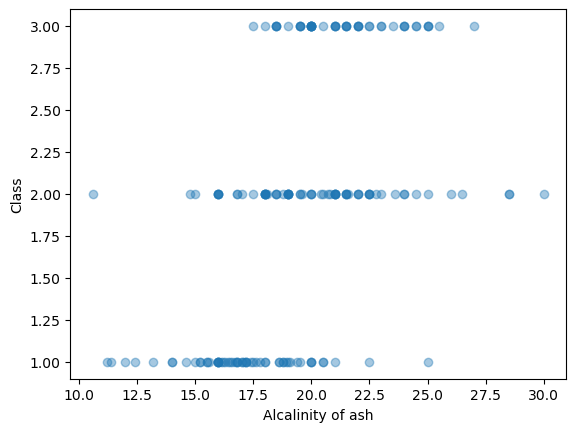

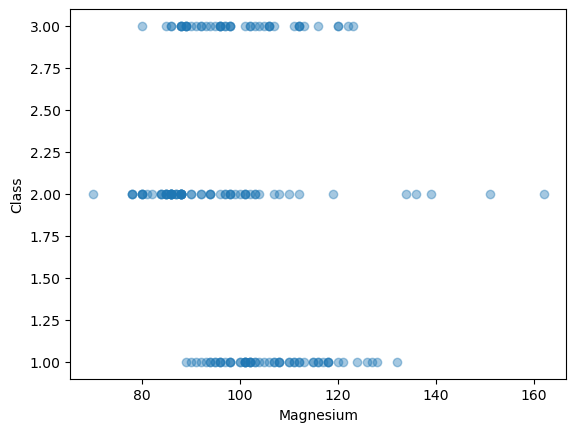

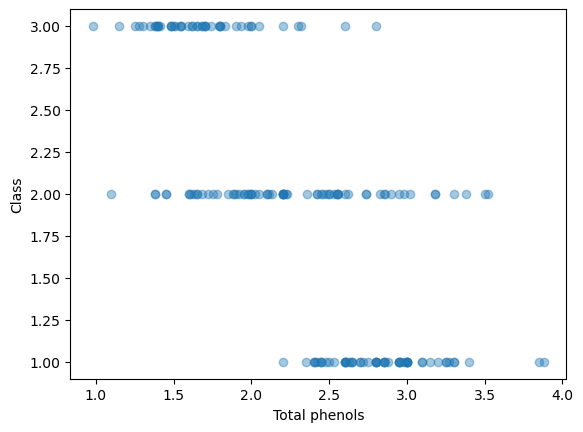

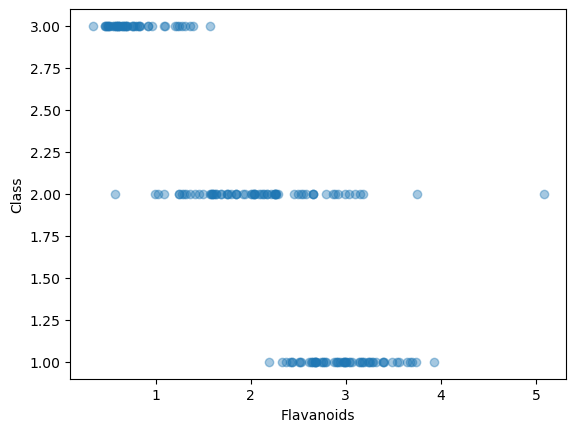

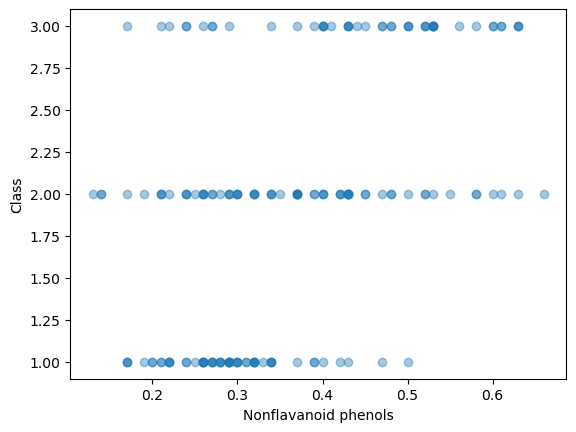

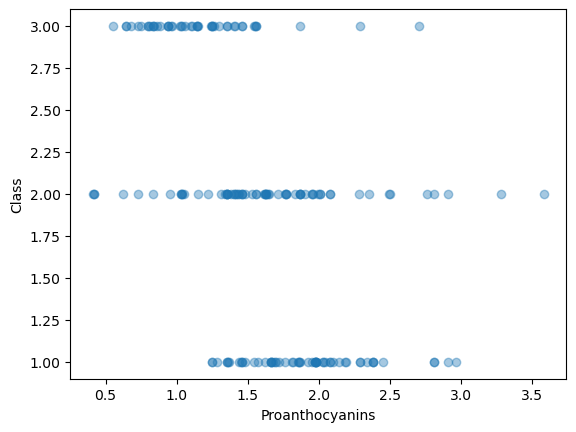

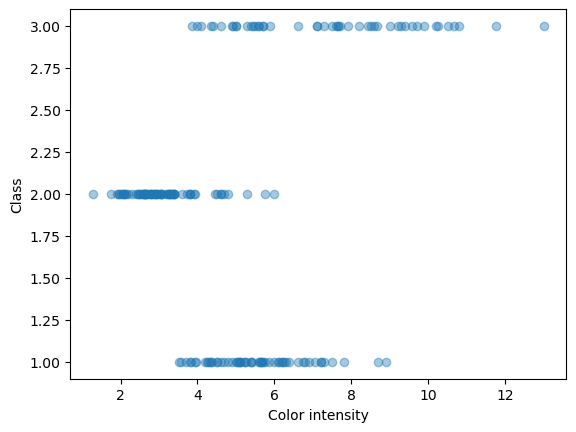

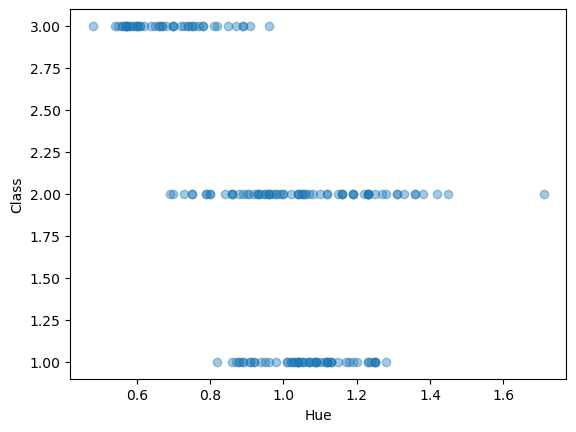

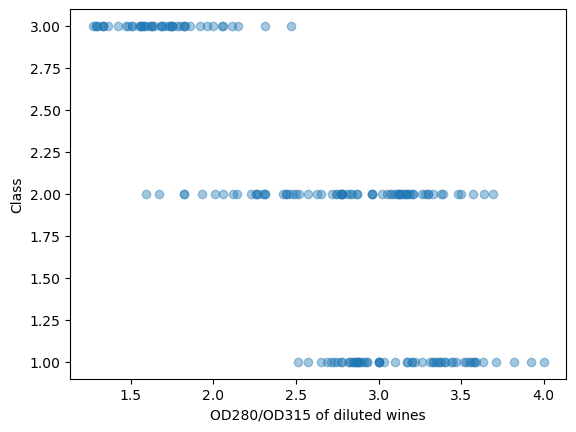

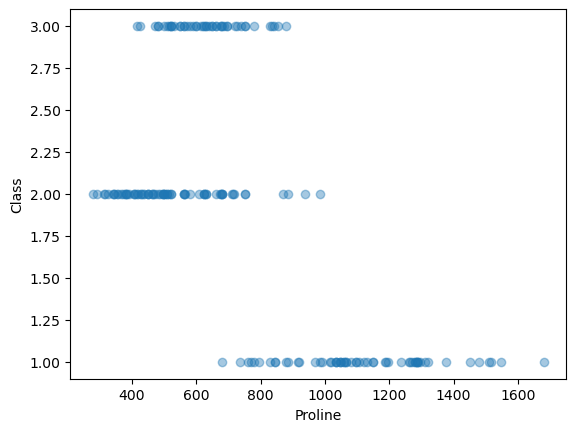

In [130]:

# Handling missing values in df2
df2 = handle_missing_values(df2)

# Computing and displaying basic statistics on the data
print(df2.describe())

# Displaying the distribution of the different classes
print("\nDistribution of Classes:\n", df2["Class"].value_counts())

# Plotting some of the numerical features against the target variable 'Class'
features_to_plot = [
    'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
]
plot_features_against_target(df2, features_to_plot, 'Class')


## Data Normalization

In [131]:
boston_target = np.array(df1['MEDV'].values)
boston_feature = np.array(df1.drop(columns='MEDV').values)

# dropping two features will make the model more precise
boston_feature = np.array(df1.drop(columns='RAD').values)
boston_feature = np.array(df1.drop(columns='TAX').values)

wine_target = np.array(df2['Class'].values)
wine_feature = np.array(df2.drop(columns='Class').values)


boston_feature_mean = boston_feature.mean(axis=0)
boston_target_mean = boston_target.mean(axis=0)
boston_feature_std = boston_feature.std(axis=0)
boston_target_std = boston_target.std(axis=0)

wine_feature_mean = wine_feature.mean(axis=0)
wine_target_mean = wine_target.mean(axis=0)
wine_feature_std = wine_feature.std(axis=0)
wine_target_std = wine_target.std(axis=0)

boston_feature = (boston_feature - boston_feature_mean) / boston_feature_std
# boston_target = (boston_target - boston_target_mean) / boston_target_std
wine_feature = (wine_feature - wine_feature_mean) / wine_feature_std
# wine_target = np.round(((wine_target - wine_target_mean) / wine_target_std)+2)

# Task 2: Implement the models

## Linear Regression

In [132]:
class LinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        # Ensure X is a 2D numpy array
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)

        # Stack a column of ones for the intercept since we are essentially multiplying intercept value by 1
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        # Calculate the pseudo-inverse of X_b and multiply by y to get the coefficients
        w_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

        self.intercept = w_best[0]
        self.coefficients = w_best[1:]

    def predict(self, X):
    # Ensure X is a 2D numpy array
      if len(X.shape) == 1:
        X = X.reshape(-1, 1)

    # Predicted values = X . coefficients + intercept
      return X.dot(self.coefficients) + self.intercept


In [133]:
class MyLinearRegression: # Specially for changing learning rates in Task 3.5
    def __init__(self, learning_rate=0.01, max_iterations=1000, regularization="l2",
                 lambda_=0.1, early_stopping=True, tol=1e-4, batch_size=None):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.regularization = regularization
        self.lambda_ = lambda_
        self.early_stopping = early_stopping
        self.tol = tol
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss = []

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        prev_loss = float('inf')

        for epoch in range(self.max_iterations):
            for X_batch, y_batch in self._batch_generator(X, y):
                model = np.dot(X_batch, self.weights) + self.bias
                dw = (1/len(X_batch)) * np.dot(X_batch.T, (model - y_batch))
                db = (1/len(X_batch)) * np.sum(model - y_batch)

                # Regularization
                if self.regularization == "l2":
                    dw += self.lambda_ * self.weights
                elif self.regularization == "l1":
                    dw += self.lambda_ * np.sign(self.weights)

                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            current_loss = np.mean((y - self.predict(X))**2)
            self.loss.append(current_loss)

            # Early stop
            if self.early_stopping and abs(prev_loss - current_loss) < self.tol:
                break

            prev_loss = current_loss

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def _batch_generator(self, X, y):
        if self.batch_size is None:
            yield X, y
        else:
            num_samples = X.shape[0]
            indices = np.random.permutation(num_samples)
            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                batch_idx = indices[start:end]
                yield X[batch_idx], y[batch_idx]

    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r2 = 1 - (ss_res / ss_tot)
        return r2

    def get_coefficients(self):
        return self.weights

    def get_intercept(self):
        return self.bias


## Logistic Regression

In [134]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=100, threshold=0.0015):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.w = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y):
        # print('fitting using logistic regression')
        # Add a column of ones for the intercept
        x = np.column_stack([np.ones(x.shape[0]), x])

        # Initialize weights
        self.w = np.zeros(x.shape[1])

        for epoch in range(self.max_iterations):
            # mean_loss = np.mean(np.abs(self.sigmoid(x.dot(self.w)) - y))
            # print("Epoch: ", epoch+1, " Loss: ", mean_loss)
            # if(mean_loss < self.threshold):
            #   break
            # Compute predictions
            predictions = self.sigmoid(x.dot(self.w))

            # Compute gradient = x(n)(y_prediction - y_real)
            gradient = x.T.dot(predictions - y)
            #print("Epoch: ", epoch+1, " Mean Gradient: ", np.mean(np.abs(gradient)))

            # Using gradient decent to get weights to minimize the cross-entropy loss
            self.w -= self.learning_rate * gradient
            if(np.mean(np.abs(gradient))<=self.threshold):
              #print("Convered in epoch: ", epoch+1, " Mean Gradient: ", np.mean(np.abs(gradient)))
              return
        #print("Did not reach convergence in ", self.max_iterations, " max iterations.")

    def predict_probabilities(self, x):
        x = np.column_stack([np.ones(x.shape[0]), x])
        return self.sigmoid(x.dot(self.w))

    def predict(self, x, threshold=0.5):
        # Compute sigmoid value, for binary classification, classified as 1 if >= threshold, as 0 if < threshold
        return (self.predict_probabilities(x) >= threshold).astype(int)

In [135]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=100, threshold=0.0015):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.classes = None
        self.threshold = threshold
        self.models = []

    def fit(self, x, y):
        # print('fitting using multi class logistic regression')
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = (y == cls).astype(int)
            model = LogisticRegression(learning_rate=self.learning_rate, max_iterations=self.max_iterations,
                                       threshold=self.threshold)
            model.fit(x, y_binary)
            self.models.append(model)

    def predict(self, x):
        # Get the probability predictions for each class
        probabilities = np.column_stack([model.predict_probabilities(x) for model in self.models])

        # Return the class with the highest probability for each sample
        return self.classes[np.argmax(probabilities, axis=1)]

## Mini-batch Stochastic Gradient Descent for Linear Regression

In [136]:
class MiniBatchLinearRegression:
    def __init__(self, learning_rate=0.001, batch_size=32, max_iterations=100, threshold=0.0001):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.w = None

    def fit(self, x, y):
        # print('fitting using mini-batch SGD linear regression')
        if isinstance(x, pd.DataFrame):
            x = np.array(x.values)
        if isinstance(y, pd.DataFrame):
            y = np.array(y.values)

        x = np.column_stack([np.ones(x.shape[0]), x])
        self.w = np.zeros(
            x.shape[1])  # Number of coefficients is number of features + 1. "+1" is due to the w0 coefficient

        gra_archive = np.array([])
        running_average = self.threshold + 1
        for epoch in range(self.max_iterations):
            # print("Epoch: ", epoch+1, " Running Average: ", running_average)
            indices = np.arange(x.shape[0])
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            for i in range(0, x.shape[0], self.batch_size):
                x_batch = x_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                y_p = np.dot(x_batch, self.w)
                gradient_w = -2 * np.dot(x_batch.T, (y_batch - y_p)) / self.batch_size
                self.w -= self.learning_rate * gradient_w

            mean_gra = np.mean(np.abs(gradient_w))
            if gra_archive.size < 7:
                gra_archive = np.append(gra_archive, mean_gra)
            elif gra_archive.size == 7:
                gra_archive = np.append(gra_archive, mean_gra)
                gra_archive = gra_archive[1:]
            running_average = np.mean(gra_archive)
            if running_average < self.threshold:
                #print("Converged in epoch: ", epoch+1, " with running average of gradient: ", running_average)
                return

        #print("Did not converge in ", self.max_iterations, " epoches, min running average achieved: ", running_average)
    def predict(self, x):
        if isinstance(x, pd.DataFrame):
            x = np.array(x.values)

        x = np.column_stack([np.ones(x.shape[0]), x])
        return x.dot(self.w)

## Mini-batch Stochastic Gradient Descent for Logistic Regression

In [137]:
class MiniBatchLogisticRegression:
    def __init__(self, learning_rate=0.01, batch_size=32, max_iterations=100,
                 threshold=0.4, regularization_strength=0.1, decay_rate=0.95):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.regularization_strength = regularization_strength
        self.decay_rate = decay_rate
        self.weights = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x, y):
        # Add a column of ones for the intercept
        x = np.column_stack([np.ones(x.shape[0]), x])

        # Initialize weights with small random values
        self.weights = np.random.randn(x.shape[1]) * 0.01

        prev_weights = np.inf

        gra_archive = np.array([])
        running_average = self.threshold + 1
        for epoch in range(self.max_iterations):
            # Shuffle the data
            indices = np.random.permutation(len(x))
            x_shuffled = x[indices]
            y_shuffled = y[indices]

            for i in range(0, len(x), self.batch_size):
                x_batch = x_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                # Compute predictions
                predictions = self.sigmoid(x_batch.dot(self.weights))

                # Compute gradient with L2 regularization
                gradient = x_batch.T.dot(predictions - y_batch) + \
                           self.regularization_strength * self.weights

                # Update weights using gradient descent
                self.weights -= self.learning_rate * gradient

            # Decay the learning rate
            self.learning_rate *= self.decay_rate

            # Check convergence based on change in weights
            if np.linalg.norm(self.weights - prev_weights) < self.threshold:
                break

            prev_weights = self.weights.copy()

    def predict_probabilities(self, x):
        x = np.column_stack([np.ones(x.shape[0]), x])
        return self.sigmoid(x.dot(self.weights))

    def predict(self, x, threshold=None):
        threshold = threshold if threshold is not None else self.threshold
        return (self.predict_probabilities(x) >= threshold).astype(int)


In [138]:
class MiniBatchMulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, batch_size=32, max_iterations=5000, threshold=0.4):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.max_iterations = max_iterations
        self.models = []
        self.threshold = threshold
        self.classes = None  # Initialize self.classes in the constructor

    def fit(self, x, y):
        # print('fitting using mini-batch SGD multi class logistic regression')
        y = np.array(y)  # Ensure y is a numpy array
        self.classes = np.unique(y)
        for cls in self.classes:
            y_binary = (y == cls).astype(int)
            model = MiniBatchLogisticRegression(learning_rate=self.learning_rate, batch_size=self.batch_size,
                                                max_iterations=self.max_iterations, threshold=self.threshold)
            model.fit(x, y_binary)
            self.models.append(model)

    def predict(self, x):
        # Get the probability predictions for each class
        probabilities = np.column_stack([model.predict_probabilities(x) for model in self.models])

        # Return the class with the highest probability for each sample
        return self.classes[np.argmax(probabilities, axis=1)]

# Task 3: Run experiments

In [139]:
# Helper function to report classification metrics
def report_classification_metrics_train(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Training Data--" "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

def report_classification_metrics_test(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Testing Data--" "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

# Helper function to report regression metrics
def report_regression_metrics_train(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {"Training Data MSE": mse}

# Helper function to report regression metrics
def report_regression_metrics_test(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {"Testing Data MSE": mse}

## 3.1

### Dataset 1

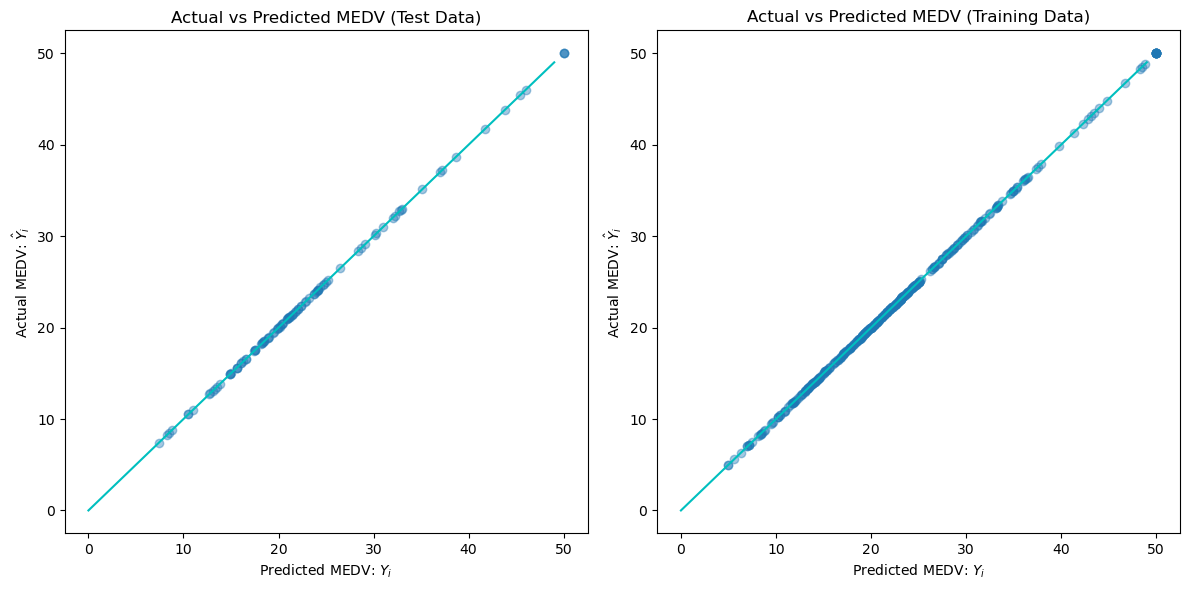

({'Testing Data MSE': 8.556820642514975e-29},
 {'Training Data MSE': 1.0981568640997453e-28})

In [140]:
# Split the data: 80/20 train/test
X_train_boston_31, x_test_boston_31, y_train_boston_31, y_test_boston_31 = train_test_split(boston_feature, boston_target,
                                                                                            train_size = 0.8, test_size = 0.2,
                                                                                            random_state=66)
Li_31 = LinearRegression()
Li_31.fit(X_train_boston_31, y_train_boston_31);

# Predictions
y_train2_boston_31 = Li_31.predict(X_train_boston_31)
y_pred_boston_31 = Li_31.predict(x_test_boston_31)


# Graph
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for Test Data
ax[0].scatter(y_pred_boston_31, y_test_boston_31, alpha=0.4)
ax[0].plot(range(50), [x for x in range(50)], 'c')
ax[0].set_xlabel("Predicted MEDV: $Y_i$")
ax[0].set_ylabel("Actual MEDV: $\hat{Y}_i$")
ax[0].set_title("Actual vs Predicted MEDV (Test Data)")

# Scatter plot for Training Data
ax[1].scatter(y_train2_boston_31, y_train_boston_31, alpha=0.4)
ax[1].plot(range(50), [x for x in range(50)], 'c')
ax[1].set_xlabel("Predicted MEDV: $Y_i$")
ax[1].set_ylabel("Actual MEDV: $\hat{Y}_i$")
ax[1].set_title("Actual vs Predicted MEDV (Training Data)")

# Show the plot
plt.tight_layout()  # adjusts subplot params so that subplot(s) fits in to the figure area.
plt.show()

# Evaluation and Metrics
boston_train_metrics_31 = report_regression_metrics_train(y_train_boston_31, y_train2_boston_31)
boston_test_metrics_31 = report_regression_metrics_test(y_test_boston_31, y_pred_boston_31)

(boston_test_metrics_31, boston_train_metrics_31)


### Dataset 2

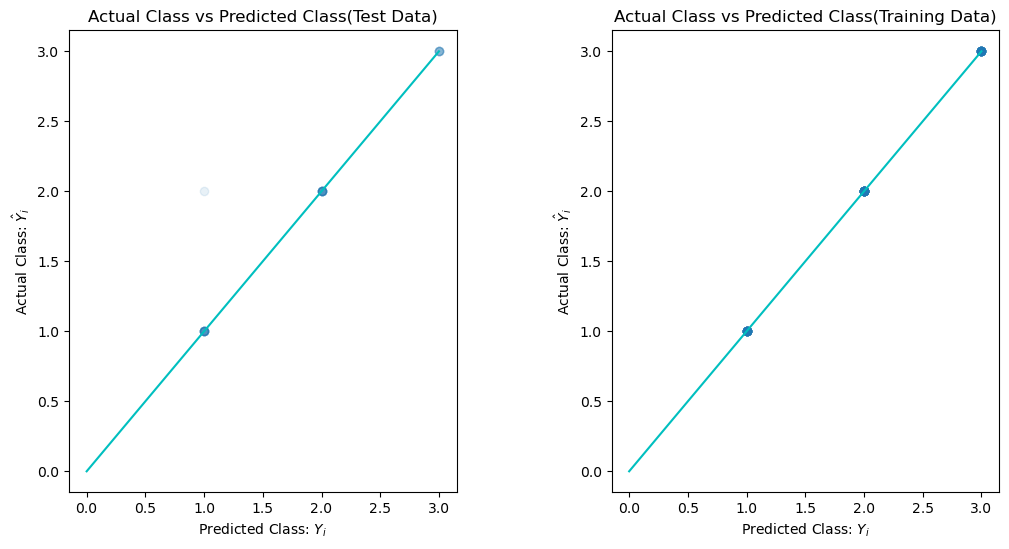

({'Training Data--Accuracy': 1.0,
  'Precision': 1.0,
  'Recall': 1.0,
  'F1 Score': 1.0},
 {'Testing Data--Accuracy': 0.9722222222222222,
  'Precision': 0.974074074074074,
  'Recall': 0.9722222222222222,
  'F1 Score': 0.9722222222222222})

In [141]:
# Split the data: 80/20 train/test
X_train_wine_31, X_test_wine_31, y_train_wine_31, y_test_wine_31 = train_test_split(wine_feature, wine_target,
                                                                                              train_size=0.8,
                                                                                              test_size=0.2,
                                                                                              random_state=66)
lr_31 = MulticlassLogisticRegression()
# LogisticRegression(learning_rate=0.01, epochs=1000)
lr_31.fit(X_train_wine_31, y_train_wine_31)

# Make predictions on the test dataset
y_pred_wine_31 = lr_31.predict(X_test_wine_31)
y_train2_wine_31 = lr_31.predict(X_train_wine_31)

# Graph
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First graph
ax[0].scatter(y_pred_wine_31, y_test_wine_31, alpha=0.1)
b = [x for x in range(4) ]
ax[0].plot(range(4), b,'c')
ax[0].set_xlabel("Predicted Class: $Y_i$")
ax[0].set_ylabel("Actual Class: $\hat{Y}_i$")
ax[0].set_title("Actual Class vs Predicted Class(Test Data)")

# Second graph
ax[1].scatter(y_train2_wine_31, y_train_wine_31, alpha=0.1)
b = [x for x in range(4) ]
ax[1].plot(range(4), b,'c')
ax[1].set_xlabel("Predicted Class: $Y_i$")
ax[1].set_ylabel("Actual Class: $\hat{Y}_i$")
ax[1].set_title("Actual Class vs Predicted Class(Training Data)")

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.4)

# Show the figure
plt.show()
# Evaluation and Metrics
wine_test_metrics = report_classification_metrics_test(y_test_wine_31, y_pred_wine_31)
wine_train_metrics = report_classification_metrics_train(y_train_wine_31, y_train2_wine_31 )

(wine_train_metrics, wine_test_metrics)


## 3.2

### Dataset 1

In [142]:
# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_errors, test_errors = [], []

# Iterate through each fold
for train_index, test_index in kf.split(boston_feature):
    X_train, X_test = boston_feature[train_index], boston_feature[test_index]
    y_train, y_test = boston_target[train_index], boston_target[test_index]

    # Train the model
    li_32 = LinearRegression()  # Instantiate model inside the loop to avoid data leakage
    li_32.fit(X_train, y_train)

    # Make predictions
    y_train_pred = li_32.predict(X_train)
    y_test_pred = li_32.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_errors.append((train_mse, train_rmse, train_mae))
    test_errors.append((test_mse, test_rmse, test_mae))

    # Print fold results
    print(f"Training MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
    print(f"Test MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")
    print("-" * 30)

# Calculate mean and standard deviation of metrics across folds
train_errors_np = np.array(train_errors)
test_errors_np = np.array(test_errors)

# Print average results
print("Average Results:")
print(f"Training MSE: {train_errors_np[:, 0].mean():.2f} ± {train_errors_np[:, 0].std():.2f}, "
      f"RMSE: {train_errors_np[:, 1].mean():.2f} ± {train_errors_np[:, 1].std():.2f}, "
      f"MAE: {train_errors_np[:, 2].mean():.2f} ± {train_errors_np[:, 2].std():.2f}")

print(f"Test MSE: {test_errors_np[:, 0].mean():.2f} ± {test_errors_np[:, 0].std():.2f}, "
      f"RMSE: {test_errors_np[:, 1].mean():.2f} ± {test_errors_np[:, 1].std():.2f}, "
      f"MAE: {test_errors_np[:, 2].mean():.2f} ± {test_errors_np[:, 2].std():.2f}")


Training MSE: 0.00, RMSE: 0.00, MAE: 0.00
Test MSE: 0.00, RMSE: 0.00, MAE: 0.00
------------------------------
Training MSE: 0.00, RMSE: 0.00, MAE: 0.00
Test MSE: 0.00, RMSE: 0.00, MAE: 0.00
------------------------------
Training MSE: 0.00, RMSE: 0.00, MAE: 0.00
Test MSE: 0.00, RMSE: 0.00, MAE: 0.00
------------------------------
Training MSE: 0.00, RMSE: 0.00, MAE: 0.00
Test MSE: 0.00, RMSE: 0.00, MAE: 0.00
------------------------------
Training MSE: 0.00, RMSE: 0.00, MAE: 0.00
Test MSE: 0.00, RMSE: 0.00, MAE: 0.00
------------------------------
Average Results:
Training MSE: 0.00 ± 0.00, RMSE: 0.00 ± 0.00, MAE: 0.00 ± 0.00
Test MSE: 0.00 ± 0.00, RMSE: 0.00 ± 0.00, MAE: 0.00 ± 0.00


### Dataset 2

In [143]:
# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
train_metrics, test_metrics = ["Train Data metrics:"], ["Test Data metrics:"]

# Iterate through each fold
for train_index, test_index in kf.split(wine_feature):
    X_train, X_test = wine_feature[train_index], wine_feature[test_index]
    y_train, y_test = wine_target[train_index], wine_target[test_index]

    # Train the model
    log_reg = MulticlassLogisticRegression(learning_rate=0.01, max_iterations=1000)
    log_reg.fit(X_train, y_train)

    # Make predictions
    y_train_pred = log_reg.predict(X_train)
    y_test_pred = log_reg.predict(X_test)

    # Compute metrics
    train_metrics.append({
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred, average='weighted'),
        "Recall": recall_score(y_train, y_train_pred, average='weighted'),
        "F1 Score": f1_score(y_train, y_train_pred, average='weighted')
    })

    test_metrics.append({
        "Test Data--Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, average='weighted'),
        "Recall": recall_score(y_test, y_test_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_test_pred, average='weighted')
    })

# Displaying the metrics for each fold
(train_metrics, test_metrics)

(['Train Data metrics:',
  {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0},
  {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0},
  {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0},
  {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0},
  {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}],
 ['Test Data metrics:',
  {'Test Data--Accuracy': 1.0,
   'Precision': 1.0,
   'Recall': 1.0,
   'F1 Score': 1.0},
  {'Test Data--Accuracy': 0.9722222222222222,
   'Precision': 0.9743589743589745,
   'Recall': 0.9722222222222222,
   'F1 Score': 0.9722222222222222},
  {'Test Data--Accuracy': 1.0,
   'Precision': 1.0,
   'Recall': 1.0,
   'F1 Score': 1.0},
  {'Test Data--Accuracy': 0.9714285714285714,
   'Precision': 0.9740259740259741,
   'Recall': 0.9714285714285714,
   'F1 Score': 0.9715374149659863},
  {'Test Data--Accuracy': 1.0,
   'Precision': 1.0,
   'Recall': 1.0,
   'F1 Score': 1.0}])

## 3.3

### Dataset 1

In [144]:
# Initializing the Linear Regression model
lr = LinearRegression()

# Lists to store performances
train_sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
mse_train_boston = []
mse_test_boston = []

# Training and evaluating the model for different training sizes
for size in train_sizes:
    # Sample the training data
    X_train_sample, X_test_boston, y_train_sample, y_test_boston = train_test_split(wine_feature, wine_target,
                                                                                              train_size=size,
                                                                                              test_size=(1-size),
                                                                                              random_state=60)

    # Train the model
    lr.fit(X_train_sample, y_train_sample)

    # Predict and evaluate
    y_pred_train = lr.predict(X_train_sample)
    y_pred_test = lr.predict(X_test_boston)

    mse_train_boston.append(mean_squared_error(y_train_sample, y_pred_train))
    mse_test_boston.append(mean_squared_error(y_test_boston, y_pred_test))

print("MSE for training sets of boston dataset:",mse_train_boston)
# mse_train_boston
print("MSE for test sets of boston dataset:", mse_test_boston)
# mse_test_boston

MSE for training sets of boston dataset: [0.05425105472931296, 0.06761326105177518, 0.06821241499911569, 0.07306685950232714, 0.06493278022141943, 0.06524784088099823, 0.06438412425895872]
MSE for test sets of boston dataset: [0.16450803982871162, 0.0827937318633771, 0.07559219088019242, 0.05261079583132685, 0.05917635807809574, 0.049386728235285525, 0.04410425007071314]


### Dataset 2

In [145]:
# ----------- WINE DATASET: Logistic Regression -----------
accuracy_train_wine = []
accuracy_test_wine = []

# Split the data: 80/20 train/test
for size in train_sizes:
    X_train_wine_33, X_test_wine_33, y_train_wine_33, y_test_wine_33 = train_test_split(wine_feature, wine_target,
                                                                                              train_size=size,
                                                                                              test_size=(1-size),
                                                                                              random_state=80)
    lr_33 = MulticlassLogisticRegression()
    lr_33.fit(X_train_wine_33, y_train_wine_33)

    # Make predictions on the test dataset
    y_pred_wine_33 = lr_33.predict(X_test_wine_33)
    y_train2_wine_33 = lr_31.predict(X_train_wine_33)

    accuracy_train_wine.append(accuracy_score(y_train_wine_33, y_train2_wine_33))
    accuracy_test_wine.append(accuracy_score(y_test_wine_33, y_pred_wine_33))

(accuracy_train_wine, accuracy_test_wine)


([1.0,
  0.9811320754716981,
  0.9859154929577465,
  0.9887640449438202,
  0.9905660377358491,
  0.9919354838709677,
  0.9929577464788732],
 [0.9440559440559441,
  0.968,
  0.9813084112149533,
  0.9775280898876404,
  0.9861111111111112,
  1.0,
  1.0])

### The graph for two datasets

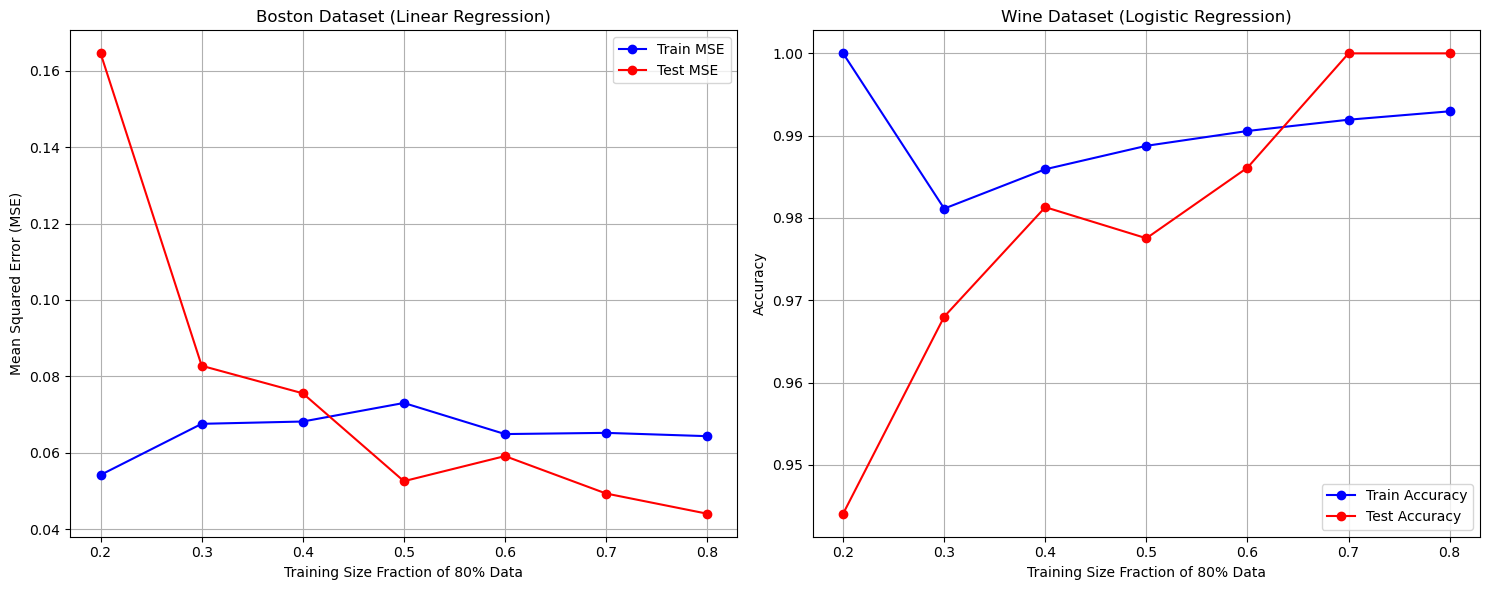

In [146]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, mse_train_boston, marker='o', label='Train MSE', color='blue')
plt.plot(train_sizes, mse_test_boston, marker='o', label='Test MSE', color='red')
plt.xlabel('Training Size Fraction of 80% Data')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Boston Dataset (Linear Regression)')
plt.legend()
plt.grid(True)

# Plotting the results for Wine dataset (Logistic Regression)
plt.subplot(1, 2, 2)
plt.plot(train_sizes, accuracy_train_wine, marker='o', label='Train Accuracy', color='blue')
plt.plot(train_sizes, accuracy_test_wine, marker='o', label='Test Accuracy', color='red')
plt.xlabel('Training Size Fraction of 80% Data')
plt.ylabel('Accuracy')
plt.title('Wine Dataset (Logistic Regression)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 3.4

### Dataset1

In [147]:
# Normalizing the Boston dataset
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(boston_feature, boston_target, test_size=0.20, random_state=66)

# Mini-batch sizes to try
batch_sizes = [8, 16, 32, 64, 128]  # Including full batch


# Re-attempting training with normalized data and recording final MSE for each batch size
final_mse_boston = []

# Training and evaluating MiniBatchLinearRegression with different batch sizes
for batch_size in batch_sizes:
    lr_mini_batch = MiniBatchLinearRegression(batch_size=batch_size, max_iterations=1000)
  # lr_mini_batch.fit(pd.DataFrame(X_train_boston_norm).reset_index(drop=True), pd.DataFrame(y_train_boston).reset_index(drop=True))
    lr_mini_batch.fit(X_train_boston, y_train_boston)
    predictions = lr_mini_batch.predict(X_test_boston)
  # report_regression_metrics(y_test_boston, predictions)
    mse = mean_squared_error(y_test_boston, predictions)
    final_mse_boston.append(mse)
print("Final MSE for boston dataset: ",final_mse_boston)

Final MSE for boston dataset:  [9.813447481632761e-07, 7.021127759126329e-06, 0.0038910695843015937, 0.08993433766703948, 0.5483313785982159]


### Dataset2

In [148]:
# Normalizing the wine dataset
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(wine_feature, wine_target,
                                                                        test_size=0.20, random_state=50)

# Mini-batch sizes to try
batch_sizes = [8, 16, 32, 64, 128]  # Including full batch


# Re-attempting training with normalized data and recording final MSE for each batch size
final_accuracy_wine = []

# Training and evaluating MiniBatchLogisticRegression with different batch sizes
for batch_size in batch_sizes:
    lr_mini_batch = MiniBatchMulticlassLogisticRegression(batch_size=batch_size)
    lr_mini_batch.fit(X_train_wine, y_train_wine)
    predictions2 = lr_mini_batch.predict(X_test_wine)
    acc = accuracy_score(y_test_wine, predictions2)
    final_accuracy_wine.append(acc)
print("Final Accuracy for wine dataset: ",final_accuracy_wine)

Final Accuracy for wine dataset:  [0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444]


## 3.5

### Dataset 1

In [149]:
# Normalizing the Boston dataset
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(boston_feature, boston_target, test_size=0.20, random_state=66)

# learning rates to try
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]


# Re-attempting training with normalized data and recording final MSE
final_mse_boston = []

# Training and evaluating MiniBatchLinearRegression with different batch sizes
for learning_rate in learning_rates:
    lr_351 = MyLinearRegression(learning_rate=learning_rate, max_iterations=200)
    lr_351.fit(X_train_boston, y_train_boston)
    predictions = lr_351.predict(X_test_boston)
    mse = mean_squared_error(y_test_boston, predictions)
    final_mse_boston.append(mse)
print("Final MSE for boston dataset: ",final_mse_boston)

Final MSE for boston dataset:  [366.1893755388628, 12.927915883381878, 0.9064149917325506, 1.750165987385794e+108, 1.7174544662794645e+270]


### Dataset 2

In [150]:
# Normalizing the wine dataset
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(wine_feature, wine_target, test_size=0.20, random_state=66)

# learning rates to try
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]


# Re-attempting training with normalized data and recording final MSE for each batch size
final_accuracy_wine = []

# Training and evaluating MiniBatchLogisticRegression with different batch sizes
for learning_rate in learning_rates:
    lr_mini_batch = MulticlassLogisticRegression(learning_rate=learning_rate, max_iterations=100)
    lr_mini_batch.fit(X_train_wine, y_train_wine)
    predictions2 = lr_mini_batch.predict(X_test_wine)
    acc = accuracy_score(y_test_wine, predictions2)
    final_accuracy_wine.append(acc)
print("Final Accuracy of wine dataset: ", final_accuracy_wine)

Final Accuracy of wine dataset:  [0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 1.0, 1.0]


## 3.6

### Dataset 1

In [151]:
# Normalizing the Boston dataset
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(boston_feature, boston_target,
                                                                                test_size=0.20, random_state=66)

# Parameters to explore
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
iterations_list = [100, 500, 1000, 1500, 2000]

# Storing results
results_boston = {}

# Training and evaluating for Boston dataset
for lr in learning_rates:
    for ep in iterations_list:
        lr_model = MyLinearRegression(learning_rate=lr, max_iterations=ep)
        lr_model.fit(X_train_boston, y_train_boston)
        predictions = lr_model.predict(X_test_boston)
        mse = mean_squared_error(y_test_boston, predictions)

        # Storing MSE for each configuration
        results_boston[(lr, ep)] = mse

# Identifying the optimal configuration for Boston dataset
optimal_config_boston = min(results_boston, key=results_boston.get)
optimal_mse_boston = results_boston[optimal_config_boston]

optimal_config_boston, optimal_mse_boston

((0.1, 500), 0.8999520946664155)

### Dataset2

In [152]:
# Normalizing the wine dataset
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(wine_feature, wine_target, test_size=0.20, random_state=66)

# Parameters to explore
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
iterations_list = [100, 500, 1000, 1500, 2000]

# Storing results
results_wine = {}

# Training and evaluating for wine dataset
for lr in learning_rates:
    for it in iterations_list:
        lr_model = MulticlassLogisticRegression(learning_rate=lr, max_iterations=ep)
        lr_model.fit(X_train_wine, y_train_wine)
        predictions = lr_model.predict(X_test_wine)
        acc = accuracy_score(y_test_wine, predictions)

        # Storing ACC for each configuration
        results_wine[(lr, it)] = acc

# Identifying the optimal configuration for wine dataset
optimal_config_wine = max(results_wine, key=results_wine.get)
optimal_acc_wine = results_wine[optimal_config_wine]

optimal_config_wine, optimal_acc_wine

((0.001, 100), 0.9722222222222222)

## 3.7

In [153]:
# Split the data
X_train_boston, X_test_boston, y_train_boston, y_test_boston = train_test_split(
    boston_feature, boston_target, test_size=0.20, random_state=66
)

# Normalize the features
scaler = StandardScaler()
X_train_boston_scaled = scaler.fit_transform(X_train_boston)
X_test_boston_scaled = scaler.transform(X_test_boston)

# Define the Gaussian basis function
def gaussian_basis_function(x, mu, s=1):
    return np.exp(-((x - mu)**2) / (2 * s**2))

# Select 5 random indices from the training data to define the centers (mu_j) of the Gaussian basis functions
np.random.seed(0)  # for reproducibility
random_indices = np.random.choice(X_train_boston_scaled.shape[0], size=5, replace=False)
mu_j = X_train_boston_scaled[random_indices]

# Create new features for the training set using the Gaussian basis functions
X_train_gaussian = np.column_stack([
    gaussian_basis_function(X_train_boston_scaled[:, col], mu[col])
    for mu in mu_j
    for col in range(X_train_boston_scaled.shape[1])
])

# Create new features for the test set using the Gaussian basis functions
X_test_gaussian = np.column_stack([
    gaussian_basis_function(X_test_boston_scaled[:, col], mu[col])
    for mu in mu_j
    for col in range(X_test_boston_scaled.shape[1])
])

# Analytical solution for linear regression: (X^T * X)^-1 * X^T * y
weights = pinv(X_train_gaussian.T @ X_train_gaussian) @ X_train_gaussian.T @ y_train_boston

# Predictions
predictions_train = X_train_gaussian @ weights
predictions_test = X_test_gaussian @ weights

# Compute MSE for train and test sets
mse_train = mean_squared_error(y_train_boston, predictions_train)
mse_test = mean_squared_error(y_test_boston, predictions_test)

(mse_train, mse_test)  # Display the training and test MSE

(1.331359822368513, 1.2305228077876005)

## 3.8

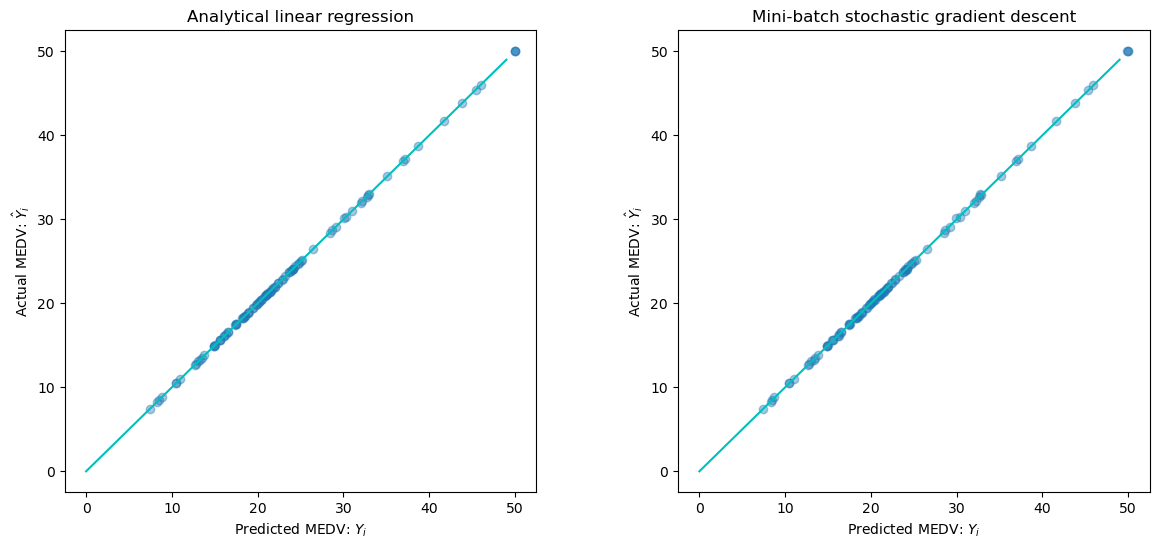

({'Testing Data MSE': 8.556820642514975e-29},
 {'Testing Data MSE': 0.0038910695843015937})

In [154]:
# Split the data: 80/20 train/test
X_train_boston_8, x_test_boston_8, y_train_boston_8, y_test_boston_8 = train_test_split(boston_feature, boston_target, train_size = 0.8, test_size = 0.2, random_state=66)

# Build the model
# alr = MyLinearRegression(learning_rate=0.02, epochs=200) # Adjusted learning rate
alr = LinearRegression() # Adjusted learning rate
minib = MiniBatchLinearRegression(batch_size=32, max_iterations=1000)

# Fit & Predict
alr.fit(X_train_boston_8, y_train_boston_8)
minib.fit(X_train_boston_8, y_train_boston_8)
y_pred_alr = alr.predict(x_test_boston_8)
y_pred_minib = minib.predict(x_test_boston_8)

# MSE
mse_alr = report_regression_metrics_test(y_pred_alr, y_test_boston_8)
mse_minib = report_regression_metrics_test(y_pred_minib, y_test_boston_8)

# Graph
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # You can adjust the figure size as per your requirement

# First subplot
ax[0].scatter(y_pred_alr, y_test_boston_8, alpha=0.4)
ax[0].plot(range(50), range(50), 'c')  # Simplified line plot code
ax[0].set_xlabel("Predicted MEDV: $Y_i$")
ax[0].set_ylabel("Actual MEDV: $\hat{Y}_i$")
ax[0].set_title("Analytical linear regression")

# Second subplot
ax[1].scatter(y_pred_minib, y_test_boston_8, alpha=0.4)
ax[1].plot(range(50), range(50), 'c')  # Simplified line plot code
ax[1].set_xlabel("Predicted MEDV: $Y_i$")
ax[1].set_ylabel("Actual MEDV: $\hat{Y}_i$")
ax[1].set_title("Mini-batch stochastic gradient descent")

plt.subplots_adjust(wspace=0.3)

plt.show()

(mse_alr, mse_minib)